In [9]:
pip install pytorch_tabnet

In [11]:
%pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=d9bf47ee6f2eac7eda778956b398e3f029bf4f17f48c32625d491a50bd659a98
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [12]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
from pathlib import Path


%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download census-income dataset

In [25]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'

# Load data and split

In [24]:
train = pd.read_csv("adult.data")
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [26]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [27]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

# Network parameters

In [28]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cpu


# Training

### We will simulate 5 targets here to perform multi regression without changing anything!

In [29]:
n_targets = 8

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
y_train = np.transpose(np.tile(y_train, (n_targets,1)))

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
y_valid = np.transpose(np.tile(y_valid, (n_targets,1)))

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
y_test = np.transpose(np.tile(y_test, (n_targets,1)))

In [30]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

epoch 0  | loss: 0.36132 | train_rmsle: 0.18928 | train_mae: 0.51788 | train_rmse: 0.81987 | train_mse: 0.67218 | valid_rmsle: 0.1823  | valid_mae: 0.5037  | valid_rmse: 0.76823 | valid_mse: 0.59018 |  0:00:03s
epoch 1  | loss: 0.15443 | train_rmsle: 0.12137 | train_mae: 0.41043 | train_rmse: 0.48728 | train_mse: 0.23745 | valid_rmsle: 0.12072 | valid_mae: 0.40812 | valid_rmse: 0.48569 | valid_mse: 0.2359  |  0:00:06s
epoch 2  | loss: 0.13819 | train_rmsle: 0.11697 | train_mae: 0.37251 | train_rmse: 0.47608 | train_mse: 0.22666 | valid_rmsle: 0.11448 | valid_mae: 0.36529 | valid_rmse: 0.47245 | valid_mse: 0.22321 |  0:00:09s
epoch 3  | loss: 0.13138 | train_rmsle: 0.09406 | train_mae: 0.33535 | train_rmse: 0.42198 | train_mse: 0.17806 | valid_rmsle: 0.09284 | valid_mae: 0.32991 | valid_rmse: 0.42048 | valid_mse: 0.1768  |  0:00:12s
epoch 4  | loss: 0.12864 | train_rmsle: 0.08511 | train_mae: 0.3031  | train_rmse: 0.39631 | train_mse: 0.15706 | valid_rmsle: 0.08115 | valid_mae: 0.29351 

In [ ]:
preds = clf.predict(X_test)

test_mse = mean_squared_error(y_pred=preds, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_mse}")

# Global explainability : feat importance summing to 1

In [33]:
clf.feature_importances_

array([1.31261891e-01, 1.36904305e-02, 3.39736011e-02, 7.67583031e-05,
       2.05220567e-01, 4.03255263e-01, 1.08939820e-02, 7.79832314e-03,
       1.87247911e-06, 0.00000000e+00, 1.63155536e-01, 4.20869261e-03,
       1.86473213e-02, 7.81576002e-03])

# Local explainability and masks

In [34]:
explain_matrix, masks = clf.explain(X_test)

In [35]:
from matplotlib import pyplot as plt
%matplotlib inline

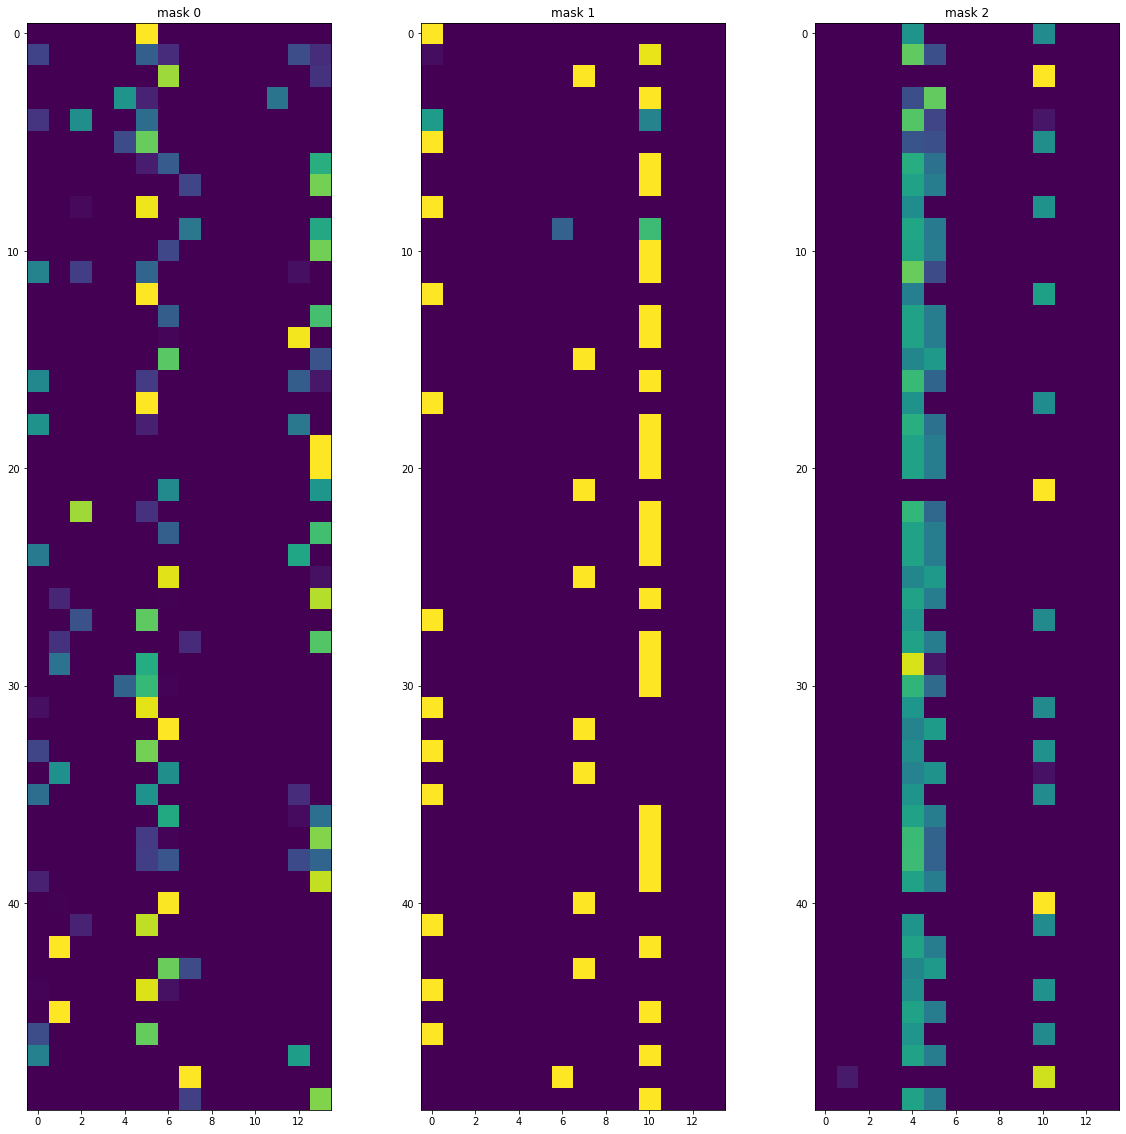

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
